# Chapter 15

## Setup and imports

In [1]:
%load_ext lab_black

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline
from tqdm import tqdm

In [4]:
nhefs_all = pd.read_excel("NHEFS.xls")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


Subset the data as described in the margin, pg 149.

In [5]:
restriction_cols = [
    "sex",
    "age",
    "race",
    "wt82",
    "ht",
    "school",
    "alcoholpy",
    "smokeintensity",
]
missing = nhefs_all[restriction_cols].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]

This time, instead of adding dummy variables and squared variables, we'll use formulas to specify Statsmodels models

## Section 15.1

### Program 15.1

"Using the same model as in Section 13.2..."

In [6]:
formula = (
    "wt82_71 ~ qsmk + qsmk:smokeintensity + sex + race + age + I(age**2) + C(education)"
    "        + smokeintensity + I(smokeintensity**2) + smokeyrs + I(smokeyrs**2)"
    "        + C(exercise) + C(active) + wt71 + I(wt71**2)"
)

ols = sm.OLS.from_formula(formula, data=nhefs)
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.5882,4.313,-0.368,0.713,-10.048,6.872
C(education)[T.2],0.7904,0.607,1.302,0.193,-0.400,1.981
C(education)[T.3],0.5563,0.556,1.000,0.317,-0.534,1.647
C(education)[T.4],1.4916,0.832,1.792,0.073,-0.141,3.124
C(education)[T.5],-0.1950,0.741,-0.263,0.793,-1.649,1.259
C(exercise)[T.1],0.2960,0.535,0.553,0.580,-0.754,1.346
C(exercise)[T.2],0.3539,0.559,0.633,0.527,-0.742,1.450
C(active)[T.1],-0.9476,0.410,-2.312,0.021,-1.752,-0.143
C(active)[T.2],-0.2614,0.685,-0.382,0.703,-1.604,1.081
qsmk,2.5596,0.809,3.163,0.002,0.972,4.147


In [7]:
print("           estimate")
print("alpha_1     {:>6.2f}".format(res.params.qsmk))
print("alpha_2     {:>6.2f}".format(res.params["qsmk:smokeintensity"]))

           estimate
alpha_1       2.56
alpha_2       0.05


To obtain the estimates of the effect of quitting smoking, we'll use a `t_test` on the fitted model

First, we'll construct the a contrast DataFrame for the 5 cigarettes/day example

In [8]:
# start with empty DataFrame
contrast = pd.DataFrame(np.zeros((2, res.params.shape[0])), columns=res.params.index)

# modify the entries
contrast["Intercept"] = 1
contrast["qsmk"] = [1, 0]
contrast["smokeintensity"] = [5, 5]
contrast["qsmk:smokeintensity"] = [5, 0]

In [9]:
contrast

,Intercept,C(education)[T.2],C(education)[T.3],C(education)[T.4],C(education)[T.5],C(exercise)[T.1],C(exercise)[T.2],C(active)[T.1],C(active)[T.2],qsmk,...,sex,race,age,I(age ** 2),smokeintensity,I(smokeintensity ** 2),smokeyrs,I(smokeyrs ** 2),wt71,I(wt71 ** 2)
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0


The effect estimate and confidence interval can be calculated with a t-test on row 0 minus row 1

In [10]:
res.t_test(contrast.iloc[0] - contrast.iloc[1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.7929      0.668      4.179      0.000       1.482       4.104

For the effect estimate with 40 cigarettes/day, we can change a few entries in the `contrast` DataFrame and again use a t-test

In [11]:
contrast["smokeintensity"] = [40, 40]
contrast["qsmk:smokeintensity"] = [40, 0]

res.t_test(contrast.iloc[0] - contrast.iloc[1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.4261      0.848      5.221      0.000       2.763       6.089

If we don't use the product term `qsmk:smokeintensity`, we get the following model and effect estimate

In [12]:
formula = (
    "wt82_71 ~ qsmk + sex + race + age + I(age**2) + C(education)"
    "        + smokeintensity + I(smokeintensity**2) + smokeyrs + I(smokeyrs**2)"
    "        + C(exercise) + C(active) + wt71 + I(wt71**2)"
)  # no qsmk_x_smokeintensity

ols = sm.OLS.from_formula(formula, data=nhefs)
res = ols.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.6586,4.314,-0.384,0.701,-10.120,6.803
C(education)[T.2],0.8185,0.607,1.349,0.178,-0.372,2.009
C(education)[T.3],0.5715,0.556,1.028,0.304,-0.519,1.662
C(education)[T.4],1.5085,0.832,1.812,0.070,-0.124,3.141
C(education)[T.5],-0.1708,0.741,-0.230,0.818,-1.625,1.283
C(exercise)[T.1],0.3207,0.535,0.599,0.549,-0.729,1.370
C(exercise)[T.2],0.3629,0.559,0.649,0.516,-0.734,1.459
C(active)[T.1],-0.9430,0.410,-2.300,0.022,-1.747,-0.139
C(active)[T.2],-0.2580,0.685,-0.377,0.706,-1.601,1.085
qsmk,3.4626,0.438,7.897,0.000,2.603,4.323


In [13]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]["qsmk"], conf_ints[1]["qsmk"]

print("           estimate   95% C.I.")
print("alpha_1     {:>5.1f}    ({:>0.1f}, {:>0.1f})".format(est, lo, hi))

           estimate   95% C.I.
alpha_1       3.5    (2.6, 4.3)


## Section 15.2

### Program 15.2

To estimate propensity score, we fit a logistic model for `qsmk` conditional on $L$

In [14]:
formula = (
    "qsmk ~ sex + race + age + I(age**2) + C(education)"
    "     + smokeintensity + I(smokeintensity**2) + smokeyrs + I(smokeyrs**2)"
    "     + C(exercise) + C(active) + wt71 + I(wt71**2)"
)

model = sm.Logit.from_formula(formula, data=nhefs_all)
res = model.fit(disp=0)

Then propensity is the predicted values

In [15]:
propensity = res.predict(nhefs_all)
nhefs_all["propensity"] = propensity

The lowest and highest propensity scores:

In [16]:
ranked = (
    nhefs_all[["seqn", "propensity"]].sort_values("propensity").reset_index(drop=True)
)

In [17]:
ranked.loc[0]

seqn          22941.000000
propensity        0.052981
Name: 0, dtype: float64

In [18]:
ranked.loc[ranked.shape[0] - 1]

seqn          24949.000000
propensity        0.793205
Name: 1628, dtype: float64

Now we'll attempt to recreate Figure 15.1, pg 45

First, we'll split the propensities based on whether the subject quit smoking

In [19]:
propensity0 = propensity[nhefs_all.qsmk == 0]
propensity1 = propensity[nhefs_all.qsmk == 1]

It looks like the bins are spaced every 0.05 (except at the right end), with the first bin starting at 0.025.

In [20]:
bins = np.arange(0.025, 0.85, 0.05)

top0, _ = np.histogram(propensity0, bins=bins)
top1, _ = np.histogram(propensity1, bins=bins)

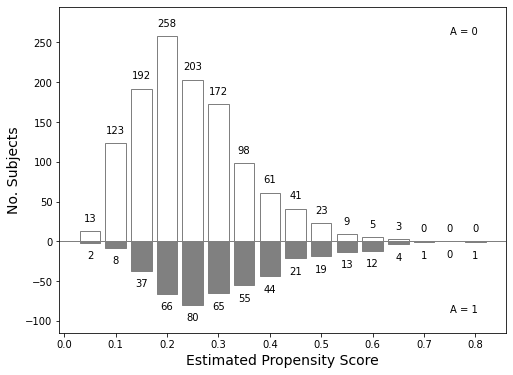

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_ylim(-115, 295)

ax.axhline(0, c="gray", linewidth=1)

bars0 = ax.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor="white")
bars1 = ax.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor="gray")

for bars in (bars0, bars1):
    for bar in bars:
        bar.set_edgecolor("gray")

for x, y in zip(bins, top0):
    ax.text(x + 0.025, y + 10, str(y), ha="center", va="bottom")

for x, y in zip(bins, top1):
    ax.text(x + 0.025, -y - 10, str(y), ha="center", va="top")

ax.text(0.75, 260, "A = 0")
ax.text(0.75, -90, "A = 1")

ax.set_ylabel("No. Subjects", fontsize=14)
ax.set_xlabel("Estimated Propensity Score", fontsize=14)

In [22]:
print("                  mean propensity")
print("    non-quitters: {:>0.3f}".format(propensity0.mean()))
print("        quitters: {:>0.3f}".format(propensity1.mean()))

                  mean propensity
    non-quitters: 0.245
        quitters: 0.312


## Section 15.3

### Program 15.3

"only individual 22005 had an estimated $\pi(L)$ of 0.6563", pg 186

In [23]:
nhefs_all[["seqn", "propensity"]].loc[abs(propensity - 0.6563) < 1e-4]

,seqn,propensity
1088,22005,0.656281


Create the deciles and check their counts

In [24]:
nhefs_all["decile"] = pd.qcut(nhefs_all.propensity, 10, labels=list(range(10)))

In [25]:
nhefs_all.decile.value_counts(sort=False)

0    163
1    163
2    163
3    163
4    163
5    162
6    163
7    163
8    163
9    163
Name: decile, dtype: int64

Now create a model with interaction between `qsmk` and $L$

In [26]:
model = sm.OLS.from_formula("wt82_71 ~ qsmk*C(decile)", data=nhefs_all)
res = model.fit()

In [27]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.9952,0.630,6.338,0.000,2.759,5.232
C(decile)[T.1],-1.0905,0.916,-1.190,0.234,-2.888,0.707
C(decile)[T.2],-1.3831,0.918,-1.506,0.132,-3.184,0.418
C(decile)[T.3],-0.5205,0.926,-0.562,0.574,-2.337,1.295
C(decile)[T.4],-1.8964,0.940,-2.017,0.044,-3.741,-0.052
C(decile)[T.5],-2.1482,0.954,-2.252,0.024,-4.019,-0.277
C(decile)[T.6],-2.4352,0.949,-2.566,0.010,-4.297,-0.574
C(decile)[T.7],-3.7105,0.974,-3.810,0.000,-5.621,-1.800
C(decile)[T.8],-4.8907,1.034,-4.731,0.000,-6.918,-2.863
C(decile)[T.9],-4.4996,1.049,-4.288,0.000,-6.558,-2.441


To get the effect estimates, we'll use t-tests with contrast DataFrames, like we did in Program 15.1

In [28]:
# start with empty DataFrame
contrast = pd.DataFrame(np.zeros((2, res.params.shape[0])), columns=res.params.index)

# modify the constant entries
contrast["Intercept"] = 1
contrast["qsmk"] = [1, 0]

# loop through t-tests, modify the DataFrame for each decile,
# and print out effect estimate and confidence intervals
print("           estimate    95% C.I.\n")
for i in range(10):
    if i != 0:
        # set the decile number
        contrast["C(decile)[T.{}]".format(i)] = [1, 1]
        contrast["qsmk:C(decile)[T.{}]".format(i)] = [1, 0]

    ttest = res.t_test(contrast.iloc[0] - contrast.iloc[1])
    est = ttest.effect[0]
    conf_ints = ttest.conf_int(alpha=0.05)
    lo, hi = conf_ints[0, 0], conf_ints[0, 1]

    print("decile {}    {:>5.1f}    ({:>4.1f},{:>4.1f})".format(i, est, lo, hi))

    if i != 0:
        # reset to zero
        contrast["C(decile)[T.{}]".format(i)] = [0, 0]
        contrast["qsmk:C(decile)[T.{}]".format(i)] = [0, 0]

           estimate    95% C.I.

decile 0     -0.0    (-4.7, 4.7)
decile 1      4.1    ( 0.9, 7.4)
decile 2      6.5    ( 3.4, 9.7)
decile 3      2.3    (-0.6, 5.2)
decile 4      4.1    ( 1.4, 6.8)
decile 5      4.5    ( 1.8, 7.2)
decile 6      4.3    ( 1.5, 7.1)
decile 7      3.6    ( 0.9, 6.2)
decile 8      2.3    (-0.2, 4.8)
decile 9      2.2    (-0.2, 4.7)


We can compare the estimates above to the estimate we get from a model without interaction between `qsmk` and $L$

In [29]:
model = sm.OLS.from_formula("wt82_71 ~ qsmk + C(decile)", data=nhefs_all)
res = model.fit()

In [30]:
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.7505,0.609,6.159,0.000,2.556,4.945
C(decile)[T.1],-0.7391,0.861,-0.858,0.391,-2.428,0.950
C(decile)[T.2],-0.6182,0.861,-0.718,0.473,-2.307,1.071
C(decile)[T.3],-0.5204,0.858,-0.606,0.544,-2.204,1.163
C(decile)[T.4],-1.4884,0.859,-1.733,0.083,-3.173,0.197
C(decile)[T.5],-1.6227,0.868,-1.871,0.062,-3.324,0.079
C(decile)[T.6],-1.9853,0.868,-2.287,0.022,-3.688,-0.282
C(decile)[T.7],-3.4447,0.875,-3.937,0.000,-5.161,-1.729
C(decile)[T.8],-5.1544,0.885,-5.825,0.000,-6.890,-3.419
C(decile)[T.9],-4.8403,0.883,-5.483,0.000,-6.572,-3.109


In [31]:
est = res.params.qsmk
conf_ints = res.conf_int(alpha=0.05, cols=None)
lo, hi = conf_ints[0]["qsmk"], conf_ints[1]["qsmk"]

print("         estimate   95% C.I.")
print("effect    {:>5.1f}    ({:>0.1f}, {:>0.1f})".format(est, lo, hi))

         estimate   95% C.I.
effect      3.5    (2.6, 4.4)


### Program 15.4

Now we will do "outcome regression $\mathrm{E}[Y|A, C=0, p(L)]$ with the estimated propensity score $p(L)$ as a continuous covariate rather than as a set of indicators" (pg 187)

In [32]:
nhefs["propensity"] = propensity[~nhefs_all.wt82_71.isnull()]

In [33]:
model = sm.OLS.from_formula("wt82_71 ~ qsmk + propensity", data=nhefs)
res = model.fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.5945,0.483,11.581,0.000,4.647,6.542
qsmk,3.5506,0.457,7.765,0.000,2.654,4.448
propensity,-14.8218,1.758,-8.433,0.000,-18.269,-11.374


From the coefficient on `qsmk` we can see the effect estimate is 3.6.

We'll use bootstrap to get confidence intervals.

In [34]:
def outcome_regress_effect(data):
    model = sm.OLS.from_formula("wt82_71 ~ qsmk + propensity", data=data)
    res = model.fit()

    data_qsmk_1 = data.copy()
    data_qsmk_1["qsmk"] = 1

    data_qsmk_0 = data.copy()
    data_qsmk_0["qsmk"] = 0

    mean_qsmk_1 = res.predict(data_qsmk_1).mean()
    mean_qsmk_0 = res.predict(data_qsmk_0).mean()

    return mean_qsmk_1 - mean_qsmk_0

In [35]:
def nonparametric_bootstrap(data, func, n=1000):
    estimate = func(data)

    n_rows = data.shape[0]
    indices = list(range(n_rows))

    b_values = []
    for _ in tqdm(range(n)):
        data_b = data.sample(n=n_rows, replace=True)
        b_values.append(func(data_b))

    std = np.std(b_values)

    return estimate, (estimate - 1.96 * std, estimate + 1.96 * std)

In [36]:
data = nhefs[["wt82_71", "qsmk", "propensity"]]

info = nonparametric_bootstrap(data, outcome_regress_effect, n=2000)

100%|██████████| 2000/2000 [04:49<00:00,  6.90it/s]


In [37]:
print("         estimate   95% C.I.")
print(
    "effect    {:>5.1f}    ({:>0.1f}, {:>0.1f})".format(info[0], info[1][0], info[1][1])
)

         estimate   95% C.I.
effect      3.6    (2.6, 4.5)
